Ethan de Villiers - 30th July, 5:30pm

The following code is part of my assessment for the Data Engineer (Health Technology) position at Imperial. For additional information, I have not left this until the last minute, but I have been very busy this week developing a cervical cancer prediction convolutional neural network which I finalised today - only after which I saw the email alerting me of my shortlisting and assessment. If you would like to view the CNN (95.6% internal accuracy, 0.8 ROC AUC) please head to my portfolio site: https://megabytten.org/cervical-cancer-cnn/

Thank you for this wonderful data project, and I apologise that this may not be my most accurate model, or most documented piece of software unfortunately due to my time constraint, but I please ask that you review some of the additional open-source software I have developed which is excellently documented and very user friendly, hosted on my portfolio site and on GitHub (https://github.com/MegaBytten?tab=repositories) as well.

Without further introduction, the following code is my relatively step-by-step thinking/processing to pipeline and model the data provided in the sqlite3 data.db

In [200]:
# data processing/pipelining libraries
import sqlite3 # db interactions
import pandas as pd # data processing
import numpy as np # arrays
import matplotlib.pyplot as plt # graphing
from datetime import datetime # date formatting (can never escape date formatting)

# Modelling libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix # reporting
import joblib # required to save model

# SECTION 1: Cleaning/Processing and Exploratory Analysis

This following section details a lot of the manual bash/UNIX commands I did on SQL - recreated in python to get a feel for the database, data, and features.

Please note each code section has a comment section up top detailing my thoughts and design choices as we progress along the code.

In [184]:
# I did the following in terminal by loading $ sqlite3 data.db -
# but here is the python equivalent to understand the database's structure and any associated tables

with sqlite3.connect('data.db') as conn:
    cursor = conn.cursor()
    schema = cursor.execute("SELECT * from sqlite_master").fetchall()
    for table in schema:
        print(table)
    

('table', 'homes', 'homes', 2, 'CREATE TABLE "homes" (\n"id" TEXT,\n  "multiple_occupancy" INTEGER\n)')
('table', 'motion', 'motion', 5, 'CREATE TABLE "motion" (\n"id" TEXT,\n  "home_id" TEXT,\n  "datetime" TEXT,\n  "location" TEXT\n)')


In [185]:
# From the above I can clearly see two tables have been created, HOMES and MOTION.
# it seems MOTION holds most of the feature data, while HOMES holds our outcome data: multiple_occupancy.
# Now lets see if we are right, and get a feel for the data inside of the tables

with sqlite3.connect('data.db') as conn:
    cursor = conn.cursor()
    
    # Fetch  count from the 'homes' table
    cursor.execute("SELECT count(*) FROM homes")
    homes_count = cursor.fetchone()[0]  # Get the count value from the tuple
    print(f"Items in table HOMES: {homes_count}")
    
    # Fetch count from the 'motion' table
    cursor.execute("SELECT count(*) FROM motion")
    motion_count = cursor.fetchone()[0]  # Get the count value from the tuple
    print(f"Items in table MOTION: {motion_count}")

Items in table HOMES: 106
Items in table MOTION: 580317


In [186]:
# We can see there is a one to many relationship between homes and motion, where home_id is the foreign key to the HOMES db
# Now lets dive into some of the actual data, and explore what our possible model features: datetime and location look like

with sqlite3.connect('data.db') as conn:
    cursor = conn.cursor()
    
    # Fetch  count from the 'homes' table
    cursor.execute("SELECT datetime, location FROM motion limit 20")
    rows = cursor.fetchall()
    for row in rows:
        print(row)

('2024-01-01 00:00:10+00', 'lounge')
('2024-01-01 00:00:17+00', 'lounge')
('2024-01-01 00:00:18+00', 'lounge')
('2024-01-01 00:00:43+00', 'lounge')
('2024-01-01 00:00:57+00', 'lounge')
('2024-01-01 00:01:24+00', 'bedroom1')
('2024-01-01 00:01:24+00', 'lounge')
('2024-01-01 00:01:24+00', 'bedroom1')
('2024-01-01 00:01:25+00', 'bedroom1')
('2024-01-01 00:01:31+00', 'lounge')
('2024-01-01 00:01:37+00', 'hallway')
('2024-01-01 00:01:40+00', 'lounge')
('2024-01-01 00:01:47+00', 'kitchen')
('2024-01-01 00:02:05+00', 'hallway')
('2024-01-01 00:02:05+00', 'kitchen')
('2024-01-01 00:02:06+00', 'bedroom1')
('2024-01-01 00:02:08+00', 'lounge')
('2024-01-01 00:02:17+00', 'lounge')
('2024-01-01 00:02:30+00', 'lounge')
('2024-01-01 00:02:40+00', 'lounge')


In [187]:
# We can see datetime is a string formatted to include date and time. We can extract lots of data from this, but will require some processing.
# Secondly we can see location is not geospatial coordinates/data, and simple non-binary categorical.
# We can likely use data from both of these database columns to train our model.
# Lets first do a sparsity analysis to see what % of the data is missing. This is important for feature selection as we cannot train a model if we are missing a lot of values.

with sqlite3.connect('data.db') as conn:
    cursor = conn.cursor()
    
    # Getting column names - using structural query PRAGMA and extracting from cursor.fetchall()
    cursor.execute("PRAGMA table_info(motion)")  # PRAGMA is SQLite-unique command for structure
    columns = []
    for item in cursor.fetchall():
        columns.append(item[1])
    
    sparsity_dict = {} # empty dict
    
    # now that we have a dynamically generated list using PRAGMA:
    # can iterate through each column and see if it has any missing values
    for column in columns:
        query = f"select count(*) from motion where {column} is NULL or {column} = '' or {column} = ' '"
        cursor.execute(query)
        count = cursor.fetchone()[0]
        sparsity_dict[column] = count

# print
for column in sparsity_dict:
    print(f"{column} had {sparsity_dict[column]} missing values")

id had 0 missing values
home_id had 0 missing values
datetime had 0 missing values
location had 0 missing values


In [188]:
# 0 sparsity! This is a very clean and well maintained dataset
# We now dont need any smart SQL queries to optimally extract data and avoid missingness,
# we can directly pull data into a pandas df for more complex processing/cleaning
# In this chunk we will manually query all columns (future-proof any schema changes to DB), and load it into a features df.

data = {} # empty dictionary to store extracted data
df = None # initialize variable in case (if rows) fails

# Connect to the database
with sqlite3.connect('data.db') as conn:
    cursor = conn.cursor()
    
    # get all data from motion - manually choose columns is better practice in case database structure changes in the future
    cursor.execute("select datetime, location, home_id, id from motion")
    rows = cursor.fetchall()
    
    # Initialize lists for each column
    date, time, location, home_id, id_list = [],[],[],[],[]

    if rows:
        for row in rows:
            datetime_value, location_value, home_id_value, id_value = row
            
            # Split datetime into date and time, removing milliseconds - potentially lost data, but only a concern if model is under-fitting.
            datetime_split = datetime_value.split()
            date.append(datetime_split[0])
            time.append(datetime_split[1][:-3])
            
            # Append other column values to respective lists
            location.append(location_value)
            home_id.append(home_id_value)
            id_list.append(id_value)

        # Convert time to numeric minutes from midnight
        def time_to_minutes(time_str):
            dt_object = datetime.strptime(time_str, '%H:%M:%S')
            return dt_object.hour * 60 + dt_object.minute + dt_object.second / 60
        
        time = list(map(time_to_minutes, time)) # apply function and save list of seconds in stead of string formatted
        
        # Create a pandas DataFrame from the collected data
        df = pd.DataFrame({
            'date': date,
            'time': time,
            'location': location,
            'home_id': home_id,
            'id': id_list
        })


print(df)  # Display the DataFrame - if any.

              date         time   location                           home_id  \
0       2024-01-01     0.166667     lounge  205c42ec747e2db13cb92087a99433f1   
1       2024-01-01     0.283333     lounge  7d2f2e0a9e059b4fb8106bb0ad4b8a39   
2       2024-01-01     0.300000     lounge  44a880cc6fc3a7db3464092f650ae7f1   
3       2024-01-01     0.716667     lounge  49b83fce41b676266b98cd1e095f1c11   
4       2024-01-01     0.950000     lounge  14328a0b7574e912c2e23d62c9476a07   
...            ...          ...        ...                               ...   
580312  2024-01-31  1438.433333  bathroom1  3a1f53e2e242bff03301a250135f894b   
580313  2024-01-31  1438.600000    kitchen  37b99328702f9fdc68c431a4ac450f2e   
580314  2024-01-31  1439.033333   bedroom1  3a1f53e2e242bff03301a250135f894b   
580315  2024-01-31  1439.150000    hallway  2b5ce37a65e82735416d69b987d99fe8   
580316  2024-01-31  1439.200000    kitchen  37b99328702f9fdc68c431a4ac450f2e   

                                      i

In [189]:
# Great - features have been extracted to a dtaframe sucessfully
# Now lets extract the outcome data to another pandas df, so that we can left-join the outcome onto features.
# we could have left-joined directly in SQLite3 and created a new table - but the design choice to do it in Pandas is because the dataset is not >10GB in size.
# If the database was larger, a left-join into a new table and then a pull into a pd df would have been chosen.

# getting all the data by column
with sqlite3.connect('data.db') as conn:
    cursor = conn.cursor()
    
    # execute the query to fetch ID and multiple_tenancy data
    cursor.execute("select id, multiple_occupancy from homes")
    rows = cursor.fetchall()
    
    ids, multiple_tenancy = [],[]

    if rows:
        # extract the data into separate lists
        for row in rows:
            ids.append(row[0])
            multiple_tenancy.append(row[1])

        # Create a pandas DataFrame from the lists
        outcome_df = pd.DataFrame({
            'id': ids,
            'multiple_tenancy': multiple_tenancy
        })

print(outcome_df)

                                   id  multiple_tenancy
0    dc922bd9bf8a2a9437642fe0dce9dcaa                 0
1    d40fc88629271da7b5833ed3f3222d17                 1
2    3fb064da180f02862063eca8e3b609c0                 1
3    16d71b9c46d9abd765bf395818efe527                 0
4    458264665736fd26184a8ea5641e6c48                 1
..                                ...               ...
101  dbe580ed60d7c329931d98a0e2ad0ea3                 1
102  04a16138cd7e0fa768858ff7c02856d8                 1
103  62c8145530aca30cb0455dc386c0a9d6                 1
104  3a5cc5ac41ab3b18b63d6d8366e30fb0                 1
105  3a1f53e2e242bff03301a250135f894b                 0

[106 rows x 2 columns]


In [190]:
# Both outcome and feature data have been extracted, now left_join outcomes onto our features for model training

outcome_df = outcome_df.rename(columns={"id": "old_id"}) # renaming id column to avoid conflicts

# ensure consistent data types for merging
outcome_df['old_id'] = outcome_df['old_id'].astype(str)
df['home_id'] = df['home_id'].astype(str)

# left join
merged_df = pd.merge(df, outcome_df, how='left', left_on='home_id', right_on='old_id')
merged_df = merged_df.drop(columns=['old_id']) # Drop extra 'old_id' column, duplicated by feature df's "home_id"

print(merged_df)

# Print unique home_id count in the original DataFrame and merged DataFrame
print("Unique home_id in df:", len(df['home_id'].unique()))
print("Unique home_id in merged_df:", len(merged_df['home_id'].unique()))

              date         time   location                           home_id  \
0       2024-01-01     0.166667     lounge  205c42ec747e2db13cb92087a99433f1   
1       2024-01-01     0.283333     lounge  7d2f2e0a9e059b4fb8106bb0ad4b8a39   
2       2024-01-01     0.300000     lounge  44a880cc6fc3a7db3464092f650ae7f1   
3       2024-01-01     0.716667     lounge  49b83fce41b676266b98cd1e095f1c11   
4       2024-01-01     0.950000     lounge  14328a0b7574e912c2e23d62c9476a07   
...            ...          ...        ...                               ...   
580312  2024-01-31  1438.433333  bathroom1  3a1f53e2e242bff03301a250135f894b   
580313  2024-01-31  1438.600000    kitchen  37b99328702f9fdc68c431a4ac450f2e   
580314  2024-01-31  1439.033333   bedroom1  3a1f53e2e242bff03301a250135f894b   
580315  2024-01-31  1439.150000    hallway  2b5ce37a65e82735416d69b987d99fe8   
580316  2024-01-31  1439.200000    kitchen  37b99328702f9fdc68c431a4ac450f2e   

                                      i

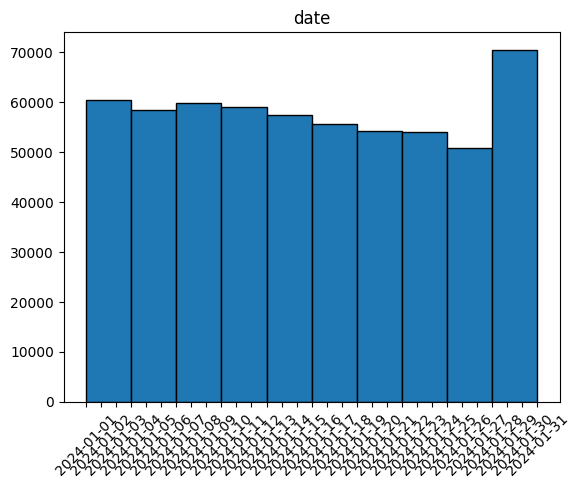

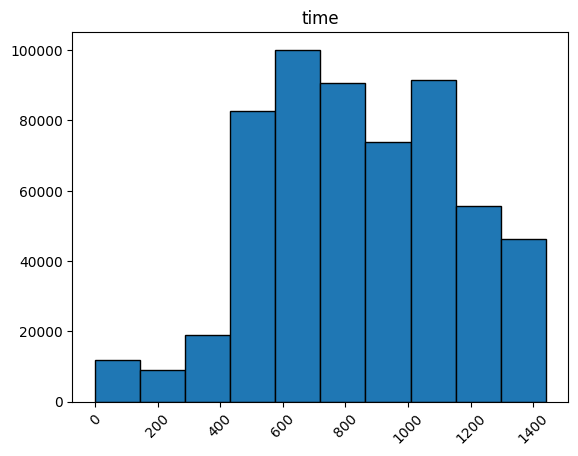

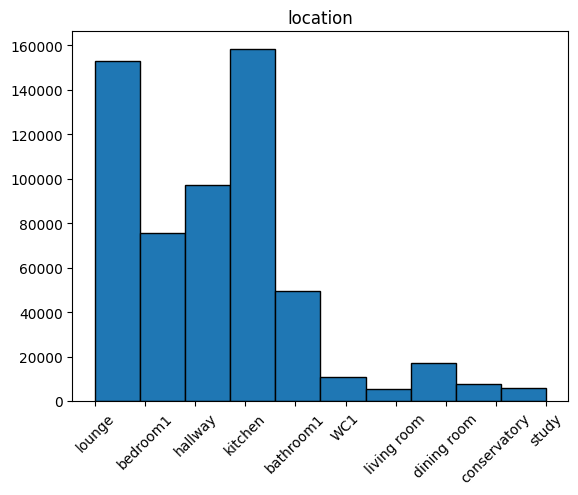

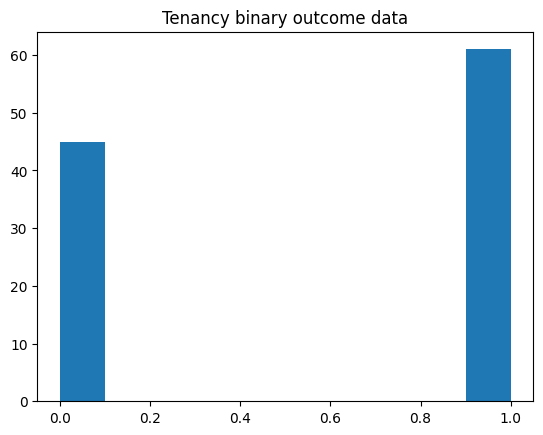

In [191]:
# Results from the previous query are very interesting. our merged df (merged_df) and our feature df (df) only have 50 unique houses, 
# while our outcome_df has 106 unique houses. This suggests not every house captures motion,
# and unfortunately further decreases our sample size for outcome training/validation - likely reducing model accuracy.
# I spent approximately 10 minutes triple-checking to ensure that we did not lose any data in the previous step

# Now that we have our combined data, let us visualise the distributions, and get a better feel of:
# - how many categories our 'location' feature has
# - when our motion data began/terminated (dates)
# - the distribution of our time (should be lower during the night)

plots = ["date", "time", "location"]

for plot in plots:
    plt.hist(merged_df[plot], edgecolor='black')
    plt.title(plot)
    plt.xticks(rotation=45)
    plt.show()

plt.hist(outcome_df['multiple_tenancy'])
plt.title("Tenancy binary outcome data")
plt.show()


## Section 1: Discussion:

We have gone through and understood the structure of the database, the quantity of data we are working with, as well as the structure of the datapoints within each value.

We conducted normal data pipeline processing/cleaning, date reformatting, getting time in a usable format, and merging our data in preparation of model development.

Finally, we used matplotlib.pyplot to visualise the distributions of our data. This is perhaps the most important step going forwards:
- Motion data spans a month from the month of Jan 2024
- Motion data was heavily non-normally distributed, with very little data collected in the morning, most data collected around midday, and then decreasing amounts collected into night time.
- Motion data was primarily captured in kitchen/lounge, followed by (not in order): bedroom bathroom and hallway.
- __Most Importantly__ Outcome data is binary! This means our prediction models will need to be classification models, such as a binomial logistic regression. Equally as important, the case/controls are relatively balanced, which makes for a sensitive and specific model. 

In order to do multiple logistic regression, all non-binary categorical variables need to be one-hot encoded (location). We'll also convert the date values from the datetime column into separated year + month + day columns for further power. 

Increasing model effectiveness usually requires standardising/normalising numeric variables. As the date values are relatively small and have a small distribution, standardisation is not essential for this. However, investigating the time distribution shows an extreme non-normal distribution of high range, which would benefit from min-max normalisation.

# Section 2: Binomial Logistic Regression: Preprocessing, training and validation + evaluation

In [192]:
# Firstly, the date data currently holds a wealth of year/month/day data that is unusable in its current string format
# lets break these apart, so that we have numeric data to feed into our model instead.


years_data, months_data, days_data = [],[],[]
for date in merged_df['date']:
    split_string = date.split('-') # split using the '-' present between yyyy-mm-dd
    years_data.append(split_string[0])
    months_data.append(split_string[1])
    days_data.append(split_string[2])

merged_df['year'] = years_data
merged_df['month'] = months_data
merged_df['day'] = days_data

# similarly, our location holds too many string levels to be of efficient use in our model
# lets one-hot encode this to binary columns associated with each location instead
merged_df = pd.get_dummies(merged_df, columns=['location'])

# finally, as previously discussed, normalising continuous variables can provide machine learning algorithms a more fair approach to scale their units
# as numeric value/range for our time can get quite large, and it has a non-normal distribution, we min-max normalise it.
# normalising time variable
time_max = merged_df['time'].max()
time_min = merged_df['time'].min()
normalised_time = []
for value in merged_df['time']:
    normalised_time.append(value - time_min /  time_max - time_min)

merged_df['normalised_time'] = normalised_time

# print df to view
print(merged_df)

              date         time                           home_id  \
0       2024-01-01     0.166667  205c42ec747e2db13cb92087a99433f1   
1       2024-01-01     0.283333  7d2f2e0a9e059b4fb8106bb0ad4b8a39   
2       2024-01-01     0.300000  44a880cc6fc3a7db3464092f650ae7f1   
3       2024-01-01     0.716667  49b83fce41b676266b98cd1e095f1c11   
4       2024-01-01     0.950000  14328a0b7574e912c2e23d62c9476a07   
...            ...          ...                               ...   
580312  2024-01-31  1438.433333  3a1f53e2e242bff03301a250135f894b   
580313  2024-01-31  1438.600000  37b99328702f9fdc68c431a4ac450f2e   
580314  2024-01-31  1439.033333  3a1f53e2e242bff03301a250135f894b   
580315  2024-01-31  1439.150000  2b5ce37a65e82735416d69b987d99fe8   
580316  2024-01-31  1439.200000  37b99328702f9fdc68c431a4ac450f2e   

                                      id  multiple_tenancy  year month day  \
0       e41218b439d933a1cd9ad158f78e9198                 1  2024    01  01   
1       92d48d8

In [ ]:
# Fantastic, data has been preprocessed into formats that can be usefully fed into our binomial logistic regression
# as previously discussed, I would have appreciated to develop a fully connected feedforward neural network for improved model complexity and accuracy.
# but due to time constraints we will stick with a simple logistic regression. - Lets use Scikit-learn to create our training and test split
# then we can train our model and test it, while recording model performance metrics

# hard-code features to use in model, extracted from merge_df.columns
features = ['year', 'month', 'day', 'location_WC1', 'location_bathroom1', 'location_bedroom1',
             'location_conservatory', 'location_dining room', 'location_hallway', 'location_kitchen',
             'location_living room', 'location_lounge', 'location_study', 'normalised_time']

X = merged_df[features]
y = merged_df['multiple_tenancy']

# Split the data into training and testing sets using scikit's train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Initialize the Logistic Regression model
# I tried numerous max iterations, diminishing returns: model performance began losing improvement at approximately 1,500-2,000 iterations
model = LogisticRegression(random_state=0)

# Train the model
model.fit(X_train, y_train)

In [194]:
# Make predictions
y_pred = model.predict(X_test)

# saving / Exporting the Model
joblib.dump(model, 'tenancy_logreg_model.pkl')

# model coefficients and intercept for reporting
for i in range(0, len(X_train.columns)):
    print(f"{X_train.columns[i]}: {model.coef_[0][i]}")
print("Intercept:", model.intercept_[0])

# MODEL EVAL:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

year: 0.0007075150611965281
month: 3.495627860211427e-07
day: -0.008795518577700053
location_WC1: -0.6142987265640885
location_bathroom1: -0.14162449872821062
location_bedroom1: -0.6226177502483364
location_conservatory: 3.587239624444616
location_dining room: -1.7444213070131847
location_hallway: 0.2656482265281044
location_kitchen: -0.7680849176890745
location_living room: -2.015823924961559
location_lounge: -1.0525068555092585
location_study: 3.106490474101128
normalised_time: 3.1045121122495746e-05
Intercept: 3.5086847963214064e-07
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.07      0.13     19539
           1       0.67      0.98      0.80     38493

    accuracy                           0.67     58032
   macro avg       0.64      0.52      0.46     58032
weighted avg       0.65      0.67      0.57     58032

Confusion Matrix:
[[ 1396 18143]
 [  886 37607]]


# Section 3: Importing and Using the Model

Very simply, the Joblib library (optimised for storing Scikit-learn models as Numpy arrays) can be used to import the model with the code seen below. To use the model is similarly as simple, I have provided a template data-preprocessing pipeline which formats the data for model usage.

In [ ]:
# LOADING the model
# import joblib  # uncomment and run if you do not have joblib loaded into the venv / runtime already
loaded_model = joblib.load('tenancy_logreg_model.pkl')

In [ ]:
# THIS CODE SECTION provides a template pipeline to convert any dataframe into a model-compatible format

# For the model to provide accurate predictions, it requires data on the following features
REQUIRED_FEATURES = [
    'year', 'month', 'day',
    'location_WC1', 'location_bathroom1', 'location_bedroom1',
    'location_conservatory', 'location_dining room', 'location_hallway',
    'location_kitchen','location_living room', 'location_lounge',
    'location_study', 'normalised_time'
]

# Firstly, with sample data, ensure the dataframe containing the prediction data has the same columns and positional indexes of the columns
sample_df = pd.df({
    'yr': [2023],
    'mo': [7],
    'day': [15],
    'loc_WC1': [0],
    'loc_bathroom1': [0],
    'loc_bedroom1': [0],
    'loc_conservatory': [0],
    'loc_dining_room': [0],
    'loc_hallway': [0],
    'loc_kitchen': [1],
    'loc_living_room': [0],
    'loc_lounge': [0],
    'loc_study': [0],
    'norm_time': [0.75]
})

# If names do not match, but positional/indexes are matched - you can use:
sample_df.columns = REQUIRED_FEATURES

# Once columns are renamed, use the model to predict values by providing the correctly-formatted df
# notice: model.predict() returns an ARRAY corresponding to the row index of the data in the dataframe. 
predictions_array = loaded_model.predict(sample_df) 

# you can save the array of predictions to a results dataframe
results_df = sample_df.copy()
results_df['predictions'] = predictions_array

# Conclusion

The logistic regression model showed an overall accuracy of 67% in classifying multi_tenancy classes, primarily hindered by the over-classification of multi-tenancy. This can be seen from the high false positive rate in the confusion matrix, while the low false negative, supplemented by the high positive class recall of 0.98 and precision of 0.67 indicates that the model can sufficiently detect multi-tenancy housing.

Although relatively under-performant/-powered, due to the high sensitivity (positive recall), this simple model can be applied as a screening tool to detect multi-tenancy houses where lead generation is important, and where false-positives are inconsequential. Further improvements would be to consider alternative model architectures (fully connected neural network with TensorFlow), to one-hot-encode the months, and to re-introduce milliseconds for possibly improved performance without enriching the data.

Overall, the work took approximately 4 hours, and the additional documentation took approximately 0.5-1 hour. I thoroughly enjoyed this project, and sincerely thank you for the potential opportunity to work with your team and help deliver the data where it needs to go!

I look forward to hearing from you soon!
Ethan de Villiers